# Bayesian Inference of NBA Player Ratings using the Pyro Probabilistic Programming Language

If you're reading this, you are probably already familiar with many of the various forms of player ratings that all get labeled some for of "+/-", including APM, RAPM, RPM, BPM, PIPM, etc. The basic idea has been described ad nauseum by this point, but briefly, we define a "stint" as a pair of home and away 5-player matchups that play consecutive possessions before a substitution is made. A stint can last anywhere from a single possession to a dozen or more. The outcome of a stint is typically the adjusted net rating (the difference in points normalized by 100 possessions). This is the very basic formulation, but depending on the priors and the target variable (for example, one can do rebound +/- just as easily), we get the many different rating systems. While I'm not going to re-invent the wheel here, I do want to show how we can formulate models in a very flexible and reasoned way using a probabilistic programming language, and specifically, [Uber's Pyro library](https://eng.uber.com/pyro/). I'm also going to show how we can use different priors to begin to explore wider possibilites for player ratings. Let's do it!

As always, we're going to first import a bunch of libraries and packages.

In [1]:
import pandas as pd
import numpy as np
import bz2
import json
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from IPython import display
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.5.0')
%matplotlib inline

Next, we're going to load 3 seasons worth of play-by-play data that I collected for [nbawowy.com](http://nbawowy.com) during the 2016-18 seasons. 

In [2]:
stints = []
with bz2.open('data/matchups-2016-2018.json.bz2', 'r') as f:
    for line in f:
        stints.append(json.loads(line))
print(stints[0][stints[0]['home']])
print(stints[0][stints[0]['away']])

{'on': ['George Hill', 'Monta Ellis', 'Paul George', 'Jordan Hill', 'Ian Mahinmi'], 'entered': [], 'exited': [], 'stats': {'poss': 6, 'time': 0, 'pts': 5, 'oreb': 1, 'dreb': 2, 'orebx': 3, 'drebx': 2, 'tov': 0, 'team_tov': 0, 'non_steal_tov': 0, 'fta': 1, 'ftm': 1, 'foul': 2, 'fgm': 2, 'fgx': 5, 'fg2m': 2, 'fg3m': 0}}
{'on': ['Mike Conley', 'Courtney Lee', 'Tony Allen', 'Zach Randolph', 'Marc Gasol'], 'entered': [], 'exited': [], 'stats': {'poss': 5, 'time': 0, 'pts': 9, 'oreb': 2, 'dreb': 3, 'orebx': 2, 'drebx': 1, 'tov': 0, 'team_tov': 0, 'non_steal_tov': 0, 'fta': 1, 'ftm': 1, 'foul': 3, 'fgm': 4, 'fgx': 4, 'fg2m': 4, 'fg3m': 0}}


You can see a stint is defined as a list of players for each team along with various stats aggregated over however many possessions were played before a substitution was made. Once we have the data loaded, the next step is to calculate the ratings and setup or feature matrix. So far this is exactly the same code that I have used previously to calculate [RAPM](https://github.com/EvanZ/nba-rapm/blob/master/rapm_splits_players.ipynb). 

In [3]:
matchups = []
ratings = []
weights = []

for stint in stints:
    home = stint['home']
    away = stint['away']
    poss = (stint[home]['stats']['poss'] + stint[away]['stats']['poss'])/2

    home_unit = {"{}".format(name): 1 for name in stint[home]['on']}
    away_unit = {"{}".format(name): -1 for name in stint[away]['on']}

    matchup = home_unit.copy()
    matchup.update(away_unit)

    if poss >= 1:  # to avoid some ill-conditioning we only use stints that have possessions >= 1
        delta = 100*(stint[home]['stats']['pts']-stint[away]['stats']['pts'])/poss
        matchups.append(matchup)
        ratings.append(delta)
        weights.append(poss)

dv = DictVectorizer(sparse=False)
features = dv.fit_transform(matchups)
players = dv.get_feature_names()
train_features, test_features, train_ratings, test_ratings, train_weights, test_weights = train_test_split(features, ratings, weights, test_size=0.15)
print(matchups[0],ratings[0],weights[0])

{'George Hill': 1, 'Monta Ellis': 1, 'Paul George': 1, 'Jordan Hill': 1, 'Ian Mahinmi': 1, 'Mike Conley': -1, 'Courtney Lee': -1, 'Tony Allen': -1, 'Zach Randolph': -1, 'Marc Gasol': -1} -72.72727272727273 5.5


Before we move on to the fun stuff, let's look at the distribution of ratings. Keep in mind each stint can have a varying amount of possessions.

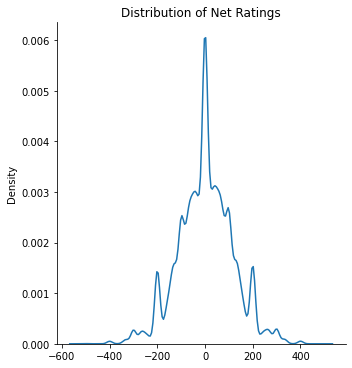

In [4]:
fig = sns.displot(data=np.array(ratings),kind='kde')
fig.set(title='Distribution of Net Ratings')

Likewise, here is the distribution of stint length. Notice that most stints are actually fairly short with very few ever going more than 15 or so possessions. Consequently, the net ratings over each stint are exceedingly noisy.

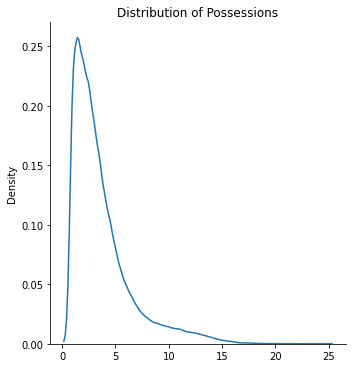

In [5]:
fig = sns.displot(data=np.array(weights),kind='kde')
fig.set(title='Distribution of Possessions')

Now that we have all the data, it's time to build the models and do some inference. First let's start with the "obvious" basic model. We assume that the ratings for each stint are distributed normally with a parameter $\mu$ and $\sigma$. Furthermore, we assume that there is a homecourt advantage $HCA$ which is positive and put a $Uniform(0,10)$ prior on it (based on my vast knowledge of NBA homecourt advantage!). For the ratings $\beta_i$, we will assign to each player a $Normal(0,1)$ prior. We'll use a $Uniform(0,200)$ prior for $sigma$. The deterministic parameter $\mu$ is then simply the sum of the $HCA$ latent variable and the player ratings $\beta$ dotted with the highly sparse feature matrix. This is all setup in the fairly simple code below.

In [6]:
# Basic model with normally distributed player ratings and stint outcomes.

def model(features, ratings):
    hca = pyro.sample("HCA", dist.Uniform(0,10))
    beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
    sigma = pyro.sample("sigma", dist.Uniform(0,200))
    for i in pyro.plate("data", len(features), subsample_size=1000):
        x = torch.Tensor(features[i])
        mu = hca + torch.dot(x, beta)
        pyro.sample(f"result_{i}", dist.Normal(mu, sigma), obs=ratings[i])

Now we'll do inference using the stochastic variational inference mode in Pyro. Note that I've split the dataset into training and test. We'll use the test set later to measure out-of-sample loss.

<AxesSubplot:>

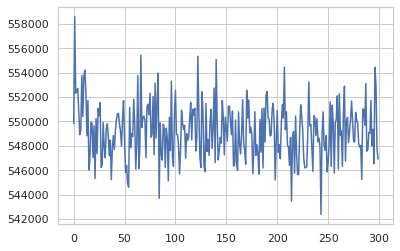

In [7]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model=model, guide=guide, optim=adam, loss=Trace_ELBO())

pyro.clear_param_store()
iters = 300
losses = []
for j in range(iters):
    # calculate the loss and take a gradient step
    loss = svi.step(train_features, train_ratings)
    losses.append(loss)
sns.set_theme(style='whitegrid')
sns.lineplot(data=losses)

Note that the loss was minimized very rapidly in this case. That is not always true. Let's see how the top 25 rankings look according to this model. In the list below you'll see 3 columns, the player, his rating, and the variance. If you haven't seen a +/- model with variances, you're not alone. It's not typically given, although I have seen it worked out previously. I encourage you to read this [blog post from Justin Jacobs on the matter](https://squared2020.com/2018/12/24/regularized-adjusted-plus-minus-part-iii-what-had-really-happened-was/). 

In [8]:
guide.requires_grad_(False)

beta_mu = pyro.param('AutoDiagonalNormal.loc')[1:]
beta_sigma = pyro.param('AutoDiagonalNormal.scale')[1:]

xpm = sorted(list(zip(beta_mu.numpy(),beta_sigma.numpy(),beta_mu.numpy()-2*beta_sigma.numpy(), beta_mu.numpy()+2*beta_sigma.numpy(),players)),key=lambda x: -x[0])
ranked_players = []
for idx, obj in enumerate(xpm):
    ranked_players.append(obj[4])
    if idx+1 <= 25:
        print(f"{idx+1}.{obj[4]} {obj[0]:0.3} ({obj[1]:.2})")

1.Stephen Curry 2.83 (0.75)
2.Draymond Green 2.3 (0.72)
3.Chris Paul 1.9 (0.7)
4.Klay Thompson 1.85 (1.2)
5.Kawhi Leonard 1.81 (0.87)
6.Russell Westbrook 1.77 (0.82)
7.Kyle Lowry 1.72 (0.72)
8.Kevin Durant 1.71 (0.86)
9.LeBron James 1.68 (1.1)
10.Eric Gordon 1.54 (0.69)
11.James Harden 1.51 (1.0)
12.Andre Iguodala 1.5 (0.86)
13.Kemba Walker 1.48 (0.92)
14.Nene 1.32 (0.91)
15.Joel Embiid 1.32 (1.1)
16.Manu Ginobili 1.31 (0.82)
17.Patrick Patterson 1.26 (0.88)
18.Rudy Gobert 1.23 (1.2)
19.Paul Millsap 1.21 (0.7)
20.Kyle Korver 1.16 (0.92)
21.J.J. Redick 1.14 (0.72)
22.Nikola Jokic 1.1 (1.4)
23.Serge Ibaka 1.09 (1.4)
24.Fred VanVleet 1.04 (0.89)
25.Davis Bertans 1.01 (0.61)


We can visualize the distributions via sampling.

<AxesSubplot:xlabel='value', ylabel='player'>

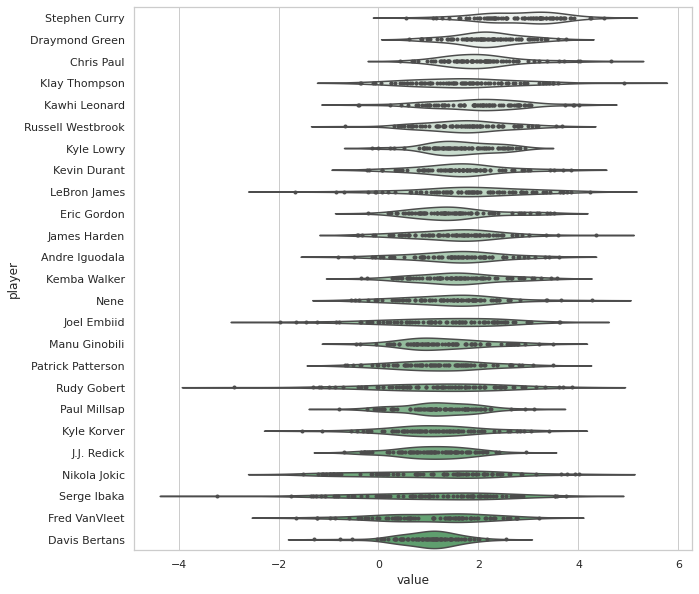

In [9]:
samples = []
for i in range(82): # 82 games!
    sample = list(zip(players,guide.sample_latent()[1:].numpy()))
    for player, value in sample:
        samples.append((player, value))
        
df = pd.DataFrame.from_records(samples,columns=['player','value'])
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data=df.where(df.player.isin(ranked_players[:25])), x='value', y='player',palette="light:g", inner="points", orient="h",order=ranked_players[:25])

We are also interested in the distributions for $HCA$ and $\sigma$ (the stint "noise"). Let's look at them together in a bivariate distribution plot (fancy!).

In [10]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=82, return_sites=("HCA","sigma"))
samples = predictive(train_features,torch.tensor(train_ratings))

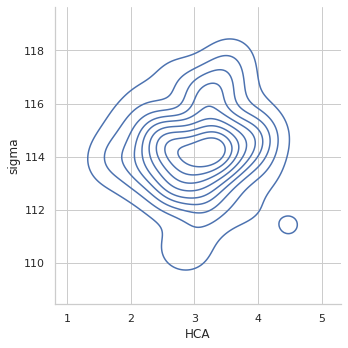

In [11]:
sns.displot(data=pd.DataFrame.from_dict(samples),x='HCA',y='sigma',kind='kde')

Well, that makes perfect sense. We know from experience that $HCA~3$ and $\sigma$ being around 115 should not be too surprising given the distribution of ratings we saw earlier. Before moving on to other models, the final piece of the puzzle is to examine the loss or error in our test data. We can then use this as a baseline for comparison. To do this we use the guide function to sample from the posterior distribution and calculate the RMSE.

In [12]:
losses = []
for i in range(len(test_features)):
    sample = guide.forward()
    mu = np.dot(test_features[i],sample['beta'])+sample['HCA']
    norm = pyro.distributions.Normal(mu, sample['sigma'])
    losses.append(np.power(norm.sample()-test_ratings[i],2))
print(f'Test Loss (RMSE) = {np.sqrt(np.mean(np.array(losses))):0.3f}')

Test Loss (RMSE) = 160.355


Ok, now let's have some fun and test some of our assumptions in the model. We assumed a normal distribution for the sampling of stint ratings. The ratings distribution given earlier seems really "pointy" at 0, reminiscent of a Laplace distribution ("double exponential"). What if we try that? See the last `pyro.sample` statement in the following code.

<AxesSubplot:>

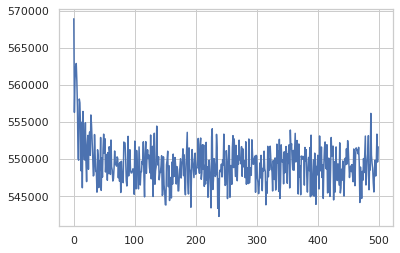

In [13]:
def model(features, ratings):
    hca = pyro.sample("HCA", dist.Uniform(0,10))
    beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
    sigma = pyro.sample("sigma", dist.Uniform(0,200))
    for i in pyro.plate("data", len(features), subsample_size=1000):
        x = torch.Tensor(features[i])
        mu = hca + torch.dot(x, beta)
        pyro.sample(f"result_{i}", dist.Laplace(mu, sigma), obs=ratings[i]) # <-----------Replaced Normal with Laplace

guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model=model, guide=guide, optim=adam, loss=Trace_ELBO())

pyro.clear_param_store()
iters = 500
losses = []
for j in range(iters):
    # calculate the loss and take a gradient step
    loss = svi.step(train_features, train_ratings)
    losses.append(loss)
    if j % 50 == 0:
        pass
#         print("[iteration %04d] loss: %.4f" % (j, loss/1000))
sns.set_theme(style='whitegrid')
sns.lineplot(data=losses)

In [14]:
guide.requires_grad_(False)

beta_mu = pyro.param('AutoDiagonalNormal.loc')[1:]
beta_sigma = pyro.param('AutoDiagonalNormal.scale')[1:]

xpm = sorted(list(zip(beta_mu.numpy(),beta_sigma.numpy(),beta_mu.numpy()-2*beta_sigma.numpy(), beta_mu.numpy()+2*beta_sigma.numpy(),players)),key=lambda x: -x[0])
ranked_players = []
for idx, obj in enumerate(xpm):
    ranked_players.append(obj[4])
    if idx+1 <= 25:
        print(f"{idx+1}.{obj[4]} {obj[0]:0.3} ({obj[1]:.2})")

1.Chris Paul 1.5 (0.96)
2.LeBron James 1.4 (0.49)
3.Stephen Curry 1.39 (0.67)
4.Kawhi Leonard 1.27 (0.52)
5.Kyle Lowry 1.2 (0.56)
6.Nikola Jokic 1.18 (0.57)
7.Draymond Green 1.12 (0.75)
8.Mike Conley 1.02 (0.44)
9.Rudy Gobert 0.996 (0.62)
10.Kevin Durant 0.954 (0.78)
11.James Harden 0.89 (0.41)
12.Russell Westbrook 0.881 (0.67)
13.Jayson Tatum 0.875 (0.77)
14.Victor Oladipo 0.866 (0.58)
15.Joel Embiid 0.841 (0.86)
16.Dejounte Murray 0.822 (0.92)
17.Nene 0.803 (0.66)
18.Klay Thompson 0.796 (0.63)
19.Kristaps Porzingis 0.794 (0.6)
20.Jrue Holiday 0.767 (0.5)
21.Kemba Walker 0.753 (0.54)
22.Serge Ibaka 0.736 (0.57)
23.Andrew Bogut 0.724 (0.72)
24.Channing Frye 0.7 (0.62)
25.Michael Kidd-Gilchrist 0.699 (0.86)


<AxesSubplot:xlabel='value', ylabel='player'>

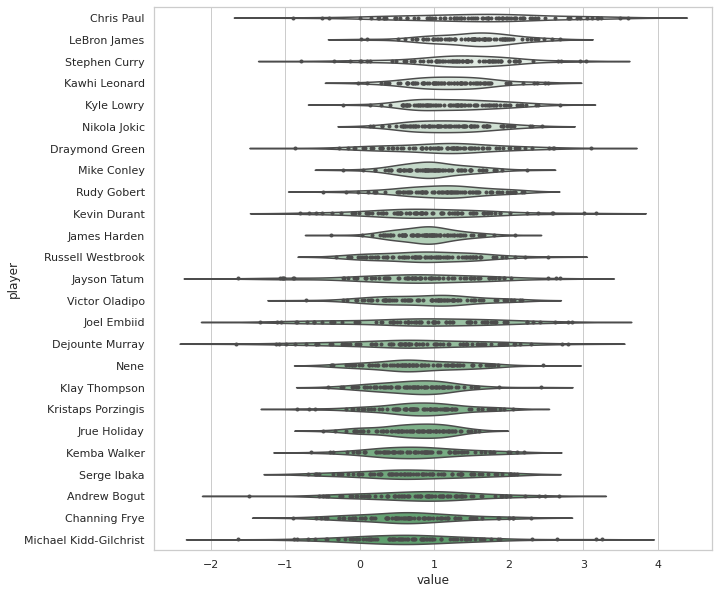

In [15]:
samples = []
for i in range(82): # 82 games!
    sample = list(zip(players,guide.sample_latent()[1:].numpy()))
    for player, value in sample:
        samples.append((player, value))
        
df = pd.DataFrame.from_records(samples,columns=['player','value'])
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data=df.where(df.player.isin(ranked_players[:25])), x='value', y='player',palette="light:g", inner="points", orient="h",order=ranked_players[:25])

Looking at the player rankings this model gives, we certainly see some differences compared to the first model, but it's not crazy. Generally speaking, we still see the best players in the league. So just looking at the rankings isn't going to give us the answer. Let's look at the test loss again.

In [16]:
losses = []
for i in range(len(test_features)):
    sample = guide.forward()
    mu = np.dot(test_features[i],sample['beta'])+sample['HCA']
    laplace = pyro.distributions.Laplace(mu, sample['sigma']) # <-----------------sample from Laplace distribution
    losses.append(np.power(laplace.sample()-test_ratings[i],2))
print(f'Test Loss (RMSE) = {np.sqrt(np.mean(np.array(losses))):0.3f}')

Test Loss (RMSE) = 169.383


Ok, well that's about 169 which is greater than the 161 we got from the original model. Let's ditch the Laplace distribution and try something a bit more "out there". So far we haven't utilized the stint lengths in our model. Just for kicks, let's try replacing the normal sampling with a Student-T distribution which uses the stint length as the degrees of freedom parameter and see what we get. 

<AxesSubplot:>

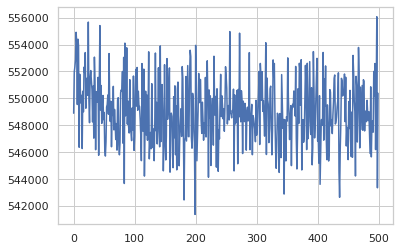

In [17]:
def model(features, ratings, weights): # <---------------------Notice we added weights as a third argument
    hca = pyro.sample("HCA", dist.Uniform(0,10))
    beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
    sigma = pyro.sample("sigma", dist.Uniform(0,200))
    for i in pyro.plate("data", len(features), subsample_size=1000):
        x = torch.Tensor(features[i])
        mu = hca + torch.dot(x, beta)
        pyro.sample(f"result_{i}", dist.StudentT(weights[i], mu, sigma), obs=ratings[i]) # <------------swap in Student-T distribution

guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model=model, guide=guide, optim=adam, loss=Trace_ELBO())

pyro.clear_param_store()
iters = 500
losses = []
for j in range(iters):
    # calculate the loss and take a gradient step
    loss = svi.step(train_features, train_ratings, train_weights) # <-------------Notice we added train_weights here
    losses.append(loss)
    if j % 50 == 0:
        pass
#         print("[iteration %04d] loss: %.4f" % (j, loss/1000))
sns.set_theme(style='whitegrid')
sns.lineplot(data=losses)

In [18]:
guide.requires_grad_(False)

beta_mu = pyro.param('AutoDiagonalNormal.loc')[1:]
beta_sigma = pyro.param('AutoDiagonalNormal.scale')[1:]

xpm = sorted(list(zip(beta_mu.numpy(),beta_sigma.numpy(),beta_mu.numpy()-2*beta_sigma.numpy(), beta_mu.numpy()+2*beta_sigma.numpy(),players)),key=lambda x: -x[0])
ranked_players = []
for idx, obj in enumerate(xpm):
    ranked_players.append(obj[4])
    if idx+1 <= 25:
        print(f"{idx+1}.{obj[4]} {obj[0]:0.3} ({obj[1]:.2})")

1.Chris Paul 3.07 (0.96)
2.Stephen Curry 2.99 (0.78)
3.LeBron James 2.5 (0.81)
4.Kevin Durant 2.47 (0.88)
5.Draymond Green 2.33 (0.65)
6.Kawhi Leonard 2.23 (1.2)
7.Nikola Jokic 2.08 (1.1)
8.Russell Westbrook 2.06 (0.69)
9.Klay Thompson 1.83 (1.3)
10.James Harden 1.83 (0.62)
11.Victor Oladipo 1.73 (0.93)
12.Rudy Gobert 1.52 (0.77)
13.Serge Ibaka 1.45 (0.8)
14.Andre Iguodala 1.43 (0.81)
15.Kyle Lowry 1.42 (0.98)
16.Gordon Hayward 1.36 (0.77)
17.Eric Gordon 1.3 (0.81)
18.J.J. Redick 1.3 (0.7)
19.Andre Roberson 1.28 (0.82)
20.Darren Collison 1.28 (0.75)
21.LaMarcus Aldridge 1.27 (0.86)
22.Kemba Walker 1.26 (0.59)
23.Kyle Korver 1.26 (0.88)
24.Mike Conley 1.25 (0.81)
25.Steven Adams 1.24 (1.1)


<AxesSubplot:xlabel='value', ylabel='player'>

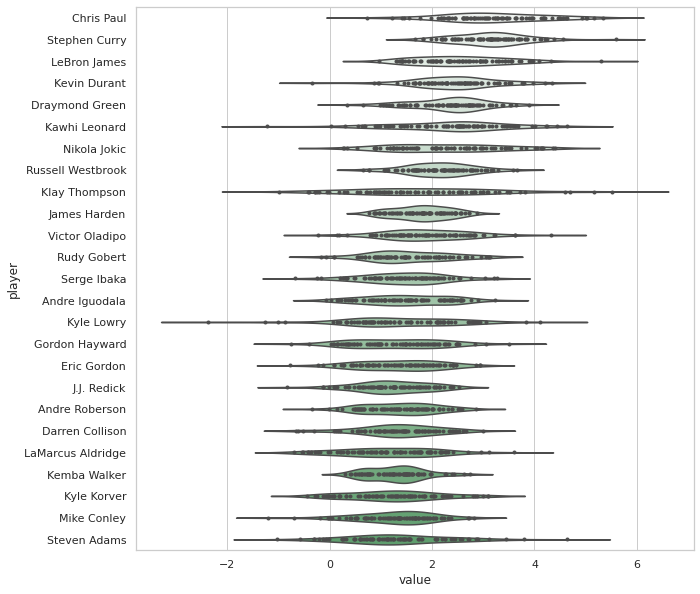

In [19]:
samples = []
for i in range(82): # 82 games!
    sample = list(zip(players,guide.sample_latent()[1:].numpy()))
    for player, value in sample:
        samples.append((player, value))
        
df = pd.DataFrame.from_records(samples,columns=['player','value'])
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data=df.where(df.player.isin(ranked_players[:25])), x='value', y='player',palette="light:g", inner="points", orient="h",order=ranked_players[:25])

Ok once again, the rankings don't seem obviously broken. But what is the loss?

In [20]:
losses = []
for i in range(len(test_features)):
    sample = guide.forward()
    mu = np.dot(test_features[i],sample['beta'])+sample['HCA']
    student_t = pyro.distributions.StudentT(test_weights[i], mu, sample['sigma']) # <-------sample from Student-T distribution and use stint length
    losses.append(np.power(student_t.sample()-test_ratings[i],2))
print(f'Test Loss (RMSE) = {np.sqrt(np.mean(np.array(losses))):0.3f}')

Test Loss (RMSE) = 21883.504


Wow, really bad. The fat tails of a Student-T doesn't seem to be a good idea, although it would be hard to notice by looking at the rankings. Ok, let's look at one more model variation. This time we will change our assumption that $\beta$ is normally distributed and instead experiment with a really fat-tailed Cauchy prior. I've never seen a +/- model that makes this assumption, so it should be interesting.

<AxesSubplot:>

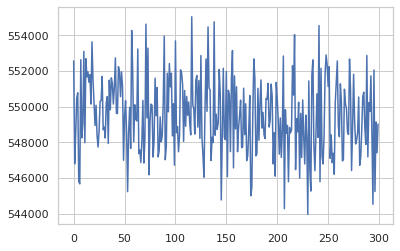

In [21]:
def model(features, ratings):
    hca = pyro.sample("HCA", dist.Uniform(0,10))
    beta = pyro.sample("beta", dist.Cauchy(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1]))) # <-----Cauchy prior 
    sigma = pyro.sample("sigma", dist.Uniform(0,200))
    for i in pyro.plate("data", len(features), subsample_size=1000):
        x = torch.Tensor(features[i])
        mu = hca + torch.dot(x, beta)
        pyro.sample(f"result_{i}", dist.Normal(mu, sigma), obs=ratings[i])

guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model=model, guide=guide, optim=adam, loss=Trace_ELBO())

pyro.clear_param_store()
iters = 300
losses = []
for j in range(iters):
    # calculate the loss and take a gradient step
    loss = svi.step(train_features, train_ratings) 
    losses.append(loss)
    if j % 50 == 0:
        pass
#         print("[iteration %04d] loss: %.4f" % (j, loss/1000))
sns.set_theme(style='whitegrid')
sns.lineplot(data=losses)

In [22]:
guide.requires_grad_(False)

beta_mu = pyro.param('AutoDiagonalNormal.loc')[1:]
beta_sigma = pyro.param('AutoDiagonalNormal.scale')[1:]

xpm = sorted(list(zip(beta_mu.numpy(),beta_sigma.numpy(),beta_mu.numpy()-2*beta_sigma.numpy(), beta_mu.numpy()+2*beta_sigma.numpy(),players)),key=lambda x: -x[0])
ranked_players = []
for idx, obj in enumerate(xpm):
    ranked_players.append(obj[4])
    if idx+1 <= 25:
        print(f"{idx+1}.{obj[4]} {obj[0]:0.3} ({obj[1]:.2})")

1.Chris Paul 4.06 (3.9)
2.Stephen Curry 3.93 (2.4)
3.LeBron James 3.33 (0.73)
4.Kyle Lowry 3.31 (2.0)
5.Draymond Green 3.29 (3.1)
6.Kawhi Leonard 3.23 (1.5)
7.Rudy Gobert 2.65 (1.4)
8.J.J. Redick 2.53 (1.6)
9.Kevin Durant 2.44 (3.3)
10.Klay Thompson 2.21 (1.7)
11.Eric Gordon 2.16 (1.3)
12.James Harden 2.01 (1.1)
13.Andre Iguodala 1.94 (1.6)
14.Russell Westbrook 1.94 (1.6)
15.Blake Griffin 1.72 (2.0)
16.Manu Ginobili 1.68 (1.5)
17.Cody Zeller 1.66 (1.5)
18.Nene 1.59 (1.2)
19.Nikola Jokic 1.52 (1.3)
20.Fred VanVleet 1.51 (2.3)
21.Kyle Korver 1.5 (2.2)
22.Delon Wright 1.47 (1.4)
23.Serge Ibaka 1.46 (1.3)
24.Boris Diaw 1.43 (0.99)
25.Mike Conley 1.4 (1.2)


<AxesSubplot:xlabel='value', ylabel='player'>

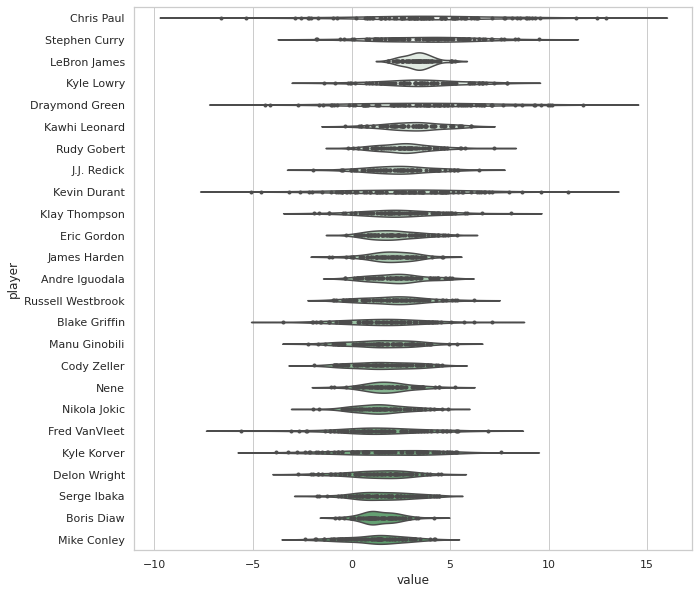

In [23]:
samples = []
for i in range(82): # 82 games!
    sample = list(zip(players,guide.sample_latent()[1:].numpy()))
    for player, value in sample:
        samples.append((player, value))

df = pd.DataFrame.from_records(samples,columns=['player','value'])
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data=df.where(df.player.isin(ranked_players[:25])), x='value', y='player',palette="light:g", inner="points", orient="h",order=ranked_players[:25])

In [24]:
losses = []
for i in range(len(test_features)):
    sample = guide.forward()
    mu = np.dot(test_features[i],sample['beta'])+sample['HCA']
    norm = pyro.distributions.Normal(mu, sample['sigma'])
    losses.append(np.power(norm.sample()-test_ratings[i],2))
print(f'Test Loss (RMSE) = {np.sqrt(np.mean(np.array(losses))):0.3f}')

Test Loss (RMSE) = 161.811


Well, hey, whaddya know. The loss is slightly higher than our original model, but not by much. It's actually a bit of a surprising result to me.

## Conclusion

Well hopefully you got something out of all this. I think the take home message from my perspective is that a PPL such as Pyro really gives you the flexibility and convenience to try out all your crazy and not-so-crazy ideas. I've only scratched the surface here. Please let me know if you have any questions or comments. You can catch me on Twitter (@thecity2).

### If you enjoyed this post please leave a Github Star!